In [110]:
#!pip install emoji
#!pip install swifter

In [111]:
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
import swifter
import string
import torch
import torch.nn as nn

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.metrics import mean_squared_error

In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
#from google.colab import drive
#drive.mount('/content/drive')

In [114]:
#df = pd.read_csv('/content/drive/MyDrive/Data Mining Project/Datasets/Code/all_posts_cleaned.csv')
posts = pd.read_csv('./all_posts_cleaned.csv')
posts.Post = posts.Post.astype(str)
posts.drop(columns=['Unnamed: 0'], inplace= True)
posts = posts.dropna()
posts

,Post,Date,Board,cleaned_post
0,I had Anal Cancer in 2008 and was successfully...,Nov 13; 2021,anal,anal successfully treated radiation years fina...
1,Hi;Â I used to be on this board every day. It ...,Aug 30; 2021,anal,used board every day lifeline wsa frightened h...
2,Hi!Â I am so very glad to see you here after a...,Sep 06; 2021,anal,glad see helped along path diagnosed years ago...
3,I have read many of your posts from way back (...,Sep 08; 2021,anal,read many posts way back fact think read every...
4,Thanks for posting this positive message!Â It...,Sep 20; 2021,anal,thanks posting positive message years since st...
...,...,...,...,...
102508,My mother was diagnosed with vulvar cancer and...,Jun 6; 2016,gynecological,mother diagnosed vulvar radical vulvectomy lym...
102509,hi I am the mother not the patient ; I have ne...,Oct 30; 2016,gynecological,mother patient never anyone life hard daughter...
102510,I just had a 3rd surgery November 1 and am wai...,Nov 26; 2016,gynecological,3rd november waiting every monday radiation da...
102511,Hope everything is going well with your daught...,Nov 26; 2016,gynecological,hope everything going well daughter dates look...


# Cleaning Post Text

In [115]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['cancer', 'chemo', 'get', 'know', 'one', 'like', 'would', 'time', 'good', 'also', 'much', 'surgery', 'treatment'])	   
stop_words = set(stop_words)

def cleanText(row):
	# Convert emoji
	row = emoji.demojize(row, delimiters = (" ", " "))
	# Lowercase all text
	row = row.lower()
	# Remove all punctuation
	row = re.sub(r'[^\w\s]', ' ', row)
	# Remove stop words and words that are 2 characters or less
	row = row.split()
	row = [w for w in row if not w in stop_words and len(w) > 2]
	row = " ".join(row)
	# Remove numbers 
	row = re.sub(r' \d+', ' ', row)
	# Remove extra space
	row = re.sub(' +', ' ', row)

	return row

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
#cleaned_posts = posts['Post'].swifter.apply(cleanText)
#posts['cleaned_post'] = cleaned_posts
#posts.to_csv('./all_posts_cleaned.csv')

# Analysis

In [117]:
cleaned_posts = posts.cleaned_post
cleaned_posts.iloc[1]

'used board every day lifeline wsa frightened hurting anal put lot happy say even though late stage weâ beat back protocol radiation simultaneously brutal alergic sulfa could give sulfadine ointment make throughout aquaphor radiation burns distant memory ten years last august anal taught lot people work rehabilitation grateful push worth discovered lymphodema faced managed successfully lymphadema result invading lymph nodes disabling learning take care hard feel everyone benefit self care give assist lymphatic system discovered first depressing daunting pleased say far bad takes manage benefits far outweigh theh challenges hang keep supporting interactions board survivors taught lot gave lot support hope needed god bless hang sandy'

In [118]:
# Number of unique words 
cnt = len(pd.unique(posts['cleaned_post']))
cnt

100056

In [119]:
MAX_FEATURES = 80000
MAX_LEN = 75

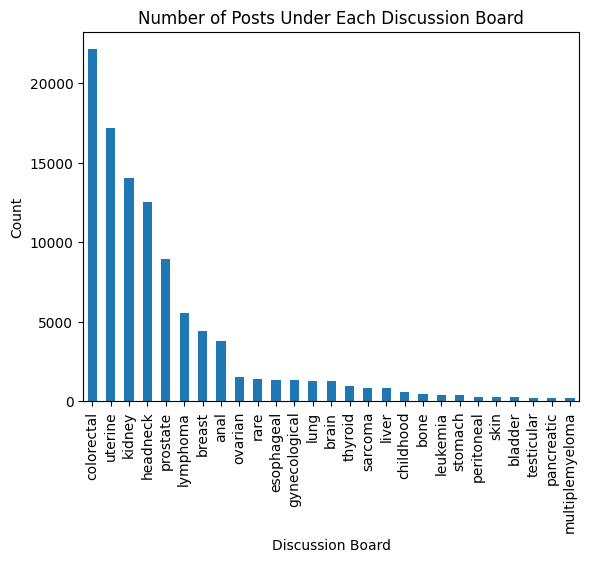

In [120]:
category_counts = posts.Board.value_counts()
category_counts.plot.bar()
plt.xticks(rotation = 90)
plt.title('Number of Posts Under Each Discussion Board')
plt.xlabel('Discussion Board')
plt.ylabel('Count')
plt.show()

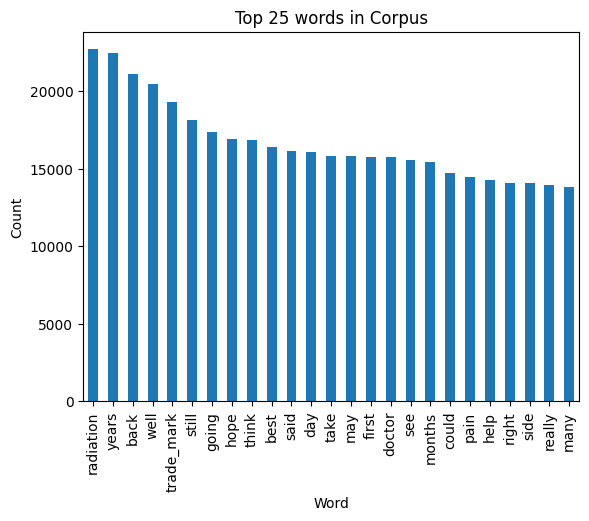

In [121]:
top_25 =  pd.Series(' '.join(cleaned_posts).split()).value_counts()[:25]
top_25.plot.bar()
plt.xticks(rotation = 90)
plt.title('Top 25 words in Corpus')
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

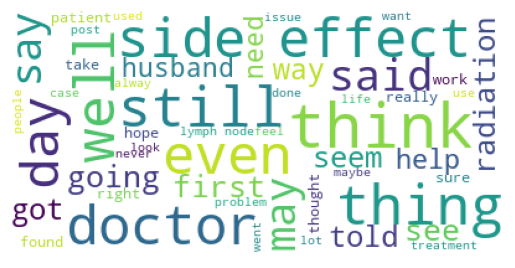

In [122]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(' '.join(cleaned_posts))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Prepare Data for Use with Torch

In [123]:
# Discussion Boards with over 1000 posts
data = posts[posts['Board'].isin(['colorectal', 'uterine', 'kidney','headneck', 'prostate', 'lymphoma', 'breast',
								  'ovarian', 'rare', 'esophageal', 'lung', 'brain', 'gynecological'])]

In [124]:
data

,Post,Date,Board,cleaned_post
4478,My mother was diagnosed with a brain tumor in ...,Nov 13; 2003,brain,mother diagnosed brain tumor june two days dia...
4479,Yes;I can relate to your situation. I too have...,Nov 14; 2003,brain,yes relate situation glioblastoma mine stage l...
4480,My cousin; was recently diagnosed with the sam...,Jul 02; 2010,brain,cousin recently diagnosed going radiation doct...
4481,I was just recently dx with a GBM in the left ...,Sep 04; 2010,brain,recently gbm left occipital lobe remove starti...
4482,My Person Email is sweetokielady72@yahoo.com y...,Aug 11; 2011,brain,person email sweetokielady72 yahoo com email w...
...,...,...,...,...
102508,My mother was diagnosed with vulvar cancer and...,Jun 6; 2016,gynecological,mother diagnosed vulvar radical vulvectomy lym...
102509,hi I am the mother not the patient ; I have ne...,Oct 30; 2016,gynecological,mother patient never anyone life hard daughter...
102510,I just had a 3rd surgery November 1 and am wai...,Nov 26; 2016,gynecological,3rd november waiting every monday radiation da...
102511,Hope everything is going well with your daught...,Nov 26; 2016,gynecological,hope everything going well daughter dates look...


In [125]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data['cleaned_post'], 
                                                    data['Board'],
                                                    test_size=0.2)

In [126]:
train_y.value_counts()

colorectal       17639
uterine          13766
kidney           11286
headneck          9993
prostate          7217
lymphoma          4409
breast            3532
ovarian           1209
rare              1094
esophageal        1073
gynecological     1071
lung              1029
brain             1023
Name: Board, dtype: int64

In [127]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

train_X = pad_sequences(train_X, maxlen=MAX_LEN)
test_X = pad_sequences(test_X, maxlen=MAX_LEN)

In [128]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [129]:
le.classes_

array(['brain', 'breast', 'colorectal', 'esophageal', 'gynecological',
       'headneck', 'kidney', 'lung', 'lymphoma', 'ovarian', 'prostate',
       'rare', 'uterine'], dtype=object)

In [130]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070 Ti'

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [132]:
# Create Torch tensors for train and validation data
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_valid = torch.tensor(test_X, dtype=torch.long).to(device)
y_valid = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_valid, y_valid)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=64, shuffle=False)

# Convolutional Neural Network (CNN)

In [133]:
import math
class CNN(nn.Module):
	def __init__(self, num_words, seq_len, embedding_sz, output_sz, kernel_sz, stride):
		super(CNN, self).__init__()

		# Setup parameters
		self.num_words = num_words
		self.seq_len = seq_len
		self.embedding_sz = embedding_sz
		self.output_sz = output_sz
		self.kernel_sz = kernel_sz
		self.stride = stride

		# Embedding Layer
		self.embedding = nn.Embedding(self.num_words + 1, 
										self.embedding_sz, 
										padding_idx=0)

		# CNN Layer
		self.conv = nn.Conv1d(self.seq_len, 
								self.output_sz, 
								self.kernel_sz, 
								self.stride)

		# Max Pooling Layer
		self.maxpool = nn.MaxPool1d(self.kernel_sz, 
									self.stride)

		# Fully Connected Layer
		self.fc = nn.Linear(self.calculateFcFeatures(), 
							len(le.classes_))

		# Dropout Layer
		self.dropout = nn.Dropout(0.1)

	def calculateFcFeatures(self):
		'''Calculates the number of output features after Convolution + Max pooling
			
		Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
		Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
		
		source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
		'''
		# Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
		out_conv_1 = ((self.embedding_sz - 1 * (self.kernel_sz - 1) - 1) / self.stride) + 1
		out_conv_1 = math.floor(out_conv_1)
		out_pool_1 = ((out_conv_1 - 1 * (self.kernel_sz - 1) - 1) / self.stride) + 1
		out_pool_1 = math.floor(out_pool_1)
		
		# Returns "flattened" vector (input for fully connected layer)
		return out_pool_1 * self.output_sz

	def forward(self, text):
		output = self.embedding(text)
		output = self.conv(output)
		output = self.maxpool(output)
		output = output.reshape(output.size(0), -1)
		output = self.fc(output)
		output = self.dropout(output)
		output = torch.relu(output)

		return output.squeeze()


# Recurrent Neural Network (RNN)

In [134]:
class RNN(nn.Module):
	def __init__(self, num_words, embedding_sz, hidden_sz, num_layers):
		super(RNN, self).__init__()
		
		# Setup Parameters
		self.num_words = num_words
		self.embedding_sz = embedding_sz
		self.hidden_sz = hidden_sz
		self.num_layers = num_layers
		
		# Embedding Layer
		self.embedding = nn.Embedding(self.num_words+1, 
									  self.embedding_sz)

		# RNN Layer
		self.rnn = nn.RNN(self.embedding_sz,
						  self.hidden_sz,
						  self.num_layers,
						  batch_first = True)
			
		# Fully Connected Layer
		self.fc = nn.Linear(self.hidden_sz, 
							len(le.classes_))

		# Dropout Layer
		self.dropout = nn.Dropout(0.2)

	def initialize_hidden_state(self, text):
		return torch.zeros((self.num_layers, text.size(0), self.hidden_sz)).to(device)

	def forward(self, text):
		self.hidden = self.initialize_hidden_state(text)
		
		output = self.embedding(text)
		output, self.hidden = self.rnn(output, self.hidden)
		output = output[:, -1, :].squeeze()
		output = self.fc(output)
		output = self.dropout(output)
		output = torch.relu(output)
		return output

# Long Short-Term Memory (LSTM)

In [135]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers, bidirectional):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim1 = hidden_dim1
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        num_directions = 2 if bidirectional else 1
        self.fc1 = nn.Linear(hidden_dim1 * num_directions, hidden_dim2 * n_layers)
        self.fc2 = nn.Linear(hidden_dim2 * n_layers, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embeds = self.embedding(text)

        output, (ht, ct) = self.lstm(embeds)
        if self.bidirectional:
          hn = torch.cat((ht[-2, :, :], ht[-1, :, :]), dim=1)
        else:
          hn = ht.view(-1, self.hidden_dim1)
        out = self.sigmoid(hn)
        out = self.fc1(hn)
        out = self.fc2(out)
        out = self.relu(out)
        return out

 # Bi-directional Long Short Term Memory (Bi-LSTM)

# Transformer encoder

In [136]:
# Reference: https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.vocab_size = vocab_size

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, nhead=8, dim_feedforward=2048, num_layers=6, dropout=0.1, activation="relu", classifier_dropout=0.1,):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(embedding_dim, len(le.classes_))
        self.d_model = embedding_dim

    def forward(self, x):
        embeds = self.embedding(x)
        x = embeds * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

# Model Training

In [163]:
# Baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(data['cleaned_post'])

In [164]:
from nltk.corpus.reader.xmldocs import XMLCorpusReader
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data['Board'], test_size=0.2, random_state=42)

In [165]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [166]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.5601528031851931

In [167]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['brain', 'breast', 'colorectal', 'esophageal', 'gynecological', 'headneck', 'kidney', 'lung', 'lymphoma', 'ovarian', 'prostate', 'rare', 'uterine'], digits=4))

               precision    recall  f1-score   support

        brain     0.3529    0.3210    0.3362       243
       breast     0.4569    0.3862    0.4186       852
   colorectal     0.5820    0.6371    0.6083      4434
   esophageal     0.4429    0.3674    0.4017       264
gynecological     0.3125    0.2434    0.2737       267
     headneck     0.6119    0.5802    0.5956      2587
       kidney     0.5700    0.5859    0.5778      2830
         lung     0.2969    0.2586    0.2764       263
     lymphoma     0.5661    0.5228    0.5436      1138
      ovarian     0.3090    0.2308    0.2642       312
     prostate     0.7092    0.6760    0.6922      1815
         rare     0.2189    0.1815    0.1984       281
      uterine     0.5233    0.5591    0.5406      3300

     accuracy                         0.5602     18586
    macro avg     0.4579    0.4269    0.4406     18586
 weighted avg     0.5567    0.5602    0.5574     18586



In [168]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average="weighted")

0.5574440531946045

In [137]:
from tqdm import tqdm

loss_func = nn.CrossEntropyLoss(reduction='sum').to(device)
def train_model(model, optimizer, epochs=10, lr=0.001):
	for i in tqdm(range(epochs)):
		model.train()
		sum_loss = 0.0
		total = 0
		for x, y in train_loader:
			y_pred = model(x)
			optimizer.zero_grad()
			loss = loss_func(y_pred, y)
			loss.backward()
			optimizer.step()
			sum_loss += loss.item()*y.shape[0]
			total += y.shape[0]
		val_loss, val_acc, val_rmse = validation_metrics(model, valid_loader)
		print("Epoch {}/{}: train loss {:.3f} \t val loss {:.3f} \t val accuracy {:.3f} \t val rmse {:.3f}"
				.format(i+1, epochs, sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_loader):
	model.eval()
	correct = 0
	total = 0
	sum_loss = 0.0
	sum_rmse = 0.0
	for x, y in valid_loader:
		y_hat = model(x)
		loss = loss_func(y_hat, y)
		pred = torch.max(y_hat, 1)[1]
		correct += (pred == y).float().sum()
		total += y.shape[0]
		sum_loss += loss.item()*y.shape[0]
		sum_rmse += np.sqrt(mean_squared_error(pred.cpu(), y.cpu().unsqueeze(-1)))*y.shape[0]
	return sum_loss/total, correct/total, sum_rmse/total

In [161]:
import torch.optim as optim

# Best CNN 
model_CNN = CNN(num_words = MAX_FEATURES, 
                seq_len = MAX_LEN, 
                embedding_sz = 128, 
                output_sz = 16, 
                kernel_sz = 2, 
                stride = 1).to(device)

# Best RNN
model_RNN = RNN(num_words = MAX_FEATURES,
 			    embedding_sz = 64,
 			    hidden_sz = 128,
 			    num_layers = 1).to(device)

# Best LSTM model:
model_LSTM = LSTM(vocab_size=MAX_FEATURES,
                  embedding_dim=400,
                  hidden_dim1=250,
                  hidden_dim2=125,
                  output_dim=len(le.classes_),
                  n_layers=2, #FIX
                  bidirectional=True).to(device)

# Best transformer encoder:
model_transformer = TransformerModel(vocab_size=MAX_FEATURES,
                                     embedding_dim=200,
                                     nhead=10,
                                     dim_feedforward=200,
                                     num_layers=2,
                                     dropout=0.0,
                                     classifier_dropout=0.0).to(device)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [162]:
models = {"CNN": model_CNN, 
		  "RNN": model_RNN,
		  "Bi-LSTM": model_LSTM,
		  "Transformer": model_transformer}

for key in models:
	print("TRAINING MODEL:", key)
	print('-' * 25)
	optimizer = optim.Adam(models[key].parameters(), lr=0.001)
	train_model(models[key], optimizer, epochs=8, lr=0.001)

TRAINING MODEL: CNN
-------------------------


 12%|█▎        | 1/8 [00:04<00:33,  4.83s/it]

Epoch 1/8: train loss 129.693 	 val loss 109.808 	 val accuracy 0.461 	 val rmse 4.730


 25%|██▌       | 2/8 [00:09<00:28,  4.73s/it]

Epoch 2/8: train loss 101.096 	 val loss 89.570 	 val accuracy 0.579 	 val rmse 4.089


 38%|███▊      | 3/8 [00:14<00:23,  4.67s/it]

Epoch 3/8: train loss 85.469 	 val loss 83.388 	 val accuracy 0.611 	 val rmse 3.885


 50%|█████     | 4/8 [00:18<00:18,  4.65s/it]

Epoch 4/8: train loss 75.801 	 val loss 82.263 	 val accuracy 0.623 	 val rmse 3.886


 62%|██████▎   | 5/8 [00:23<00:13,  4.63s/it]

Epoch 5/8: train loss 69.014 	 val loss 82.197 	 val accuracy 0.631 	 val rmse 3.801


 75%|███████▌  | 6/8 [00:27<00:09,  4.62s/it]

Epoch 6/8: train loss 63.846 	 val loss 83.677 	 val accuracy 0.633 	 val rmse 3.757


 88%|████████▊ | 7/8 [00:32<00:04,  4.61s/it]

Epoch 7/8: train loss 59.324 	 val loss 86.643 	 val accuracy 0.630 	 val rmse 3.858


100%|██████████| 8/8 [00:37<00:00,  4.63s/it]


Epoch 8/8: train loss 56.324 	 val loss 89.428 	 val accuracy 0.631 	 val rmse 3.838
TRAINING MODEL: RNN
-------------------------


 12%|█▎        | 1/8 [00:05<00:38,  5.52s/it]

Epoch 1/8: train loss 138.696 	 val loss 127.921 	 val accuracy 0.339 	 val rmse 5.268


 25%|██▌       | 2/8 [00:11<00:33,  5.53s/it]

Epoch 2/8: train loss 133.887 	 val loss 127.851 	 val accuracy 0.336 	 val rmse 5.227


 38%|███▊      | 3/8 [00:16<00:27,  5.57s/it]

Epoch 3/8: train loss 130.138 	 val loss 123.690 	 val accuracy 0.368 	 val rmse 5.112


 50%|█████     | 4/8 [00:22<00:22,  5.58s/it]

Epoch 4/8: train loss 127.128 	 val loss 116.600 	 val accuracy 0.413 	 val rmse 4.739


 62%|██████▎   | 5/8 [00:28<00:16,  5.66s/it]

Epoch 5/8: train loss 122.602 	 val loss 116.705 	 val accuracy 0.410 	 val rmse 4.955


 75%|███████▌  | 6/8 [00:33<00:11,  5.72s/it]

Epoch 6/8: train loss 122.277 	 val loss 115.998 	 val accuracy 0.419 	 val rmse 4.721


 88%|████████▊ | 7/8 [00:39<00:05,  5.74s/it]

Epoch 7/8: train loss 118.129 	 val loss 114.904 	 val accuracy 0.433 	 val rmse 4.835


100%|██████████| 8/8 [00:45<00:00,  5.69s/it]


Epoch 8/8: train loss 121.680 	 val loss 120.733 	 val accuracy 0.380 	 val rmse 4.513
TRAINING MODEL: Bi-LSTM
-------------------------


 12%|█▎        | 1/8 [00:26<03:07, 26.81s/it]

Epoch 1/8: train loss 102.565 	 val loss 74.044 	 val accuracy 0.636 	 val rmse 3.755


 25%|██▌       | 2/8 [00:52<02:38, 26.35s/it]

Epoch 2/8: train loss 61.514 	 val loss 62.757 	 val accuracy 0.690 	 val rmse 3.488


 38%|███▊      | 3/8 [01:18<02:11, 26.23s/it]

Epoch 3/8: train loss 41.962 	 val loss 63.242 	 val accuracy 0.704 	 val rmse 3.274


 50%|█████     | 4/8 [01:46<01:46, 26.63s/it]

Epoch 4/8: train loss 26.012 	 val loss 74.142 	 val accuracy 0.698 	 val rmse 3.246


 62%|██████▎   | 5/8 [02:14<01:21, 27.19s/it]

Epoch 5/8: train loss 17.005 	 val loss 87.612 	 val accuracy 0.691 	 val rmse 3.298


 75%|███████▌  | 6/8 [02:42<00:55, 27.58s/it]

Epoch 6/8: train loss 11.815 	 val loss 100.118 	 val accuracy 0.687 	 val rmse 3.299


 88%|████████▊ | 7/8 [03:10<00:27, 27.62s/it]

Epoch 7/8: train loss 9.287 	 val loss 107.198 	 val accuracy 0.688 	 val rmse 3.314


100%|██████████| 8/8 [03:37<00:00, 27.19s/it]


Epoch 8/8: train loss 7.874 	 val loss 113.423 	 val accuracy 0.687 	 val rmse 3.330
TRAINING MODEL: Transformer
-------------------------


 12%|█▎        | 1/8 [00:11<01:23, 11.99s/it]

Epoch 1/8: train loss 123.375 	 val loss 112.159 	 val accuracy 0.404 	 val rmse 3.910


 25%|██▌       | 2/8 [00:23<01:11, 11.98s/it]

Epoch 2/8: train loss 99.264 	 val loss 93.754 	 val accuracy 0.532 	 val rmse 4.242


 38%|███▊      | 3/8 [00:35<00:59, 11.99s/it]

Epoch 3/8: train loss 83.051 	 val loss 79.484 	 val accuracy 0.611 	 val rmse 3.772


 50%|█████     | 4/8 [00:47<00:47, 12.00s/it]

Epoch 4/8: train loss 72.970 	 val loss 74.099 	 val accuracy 0.635 	 val rmse 3.585


 62%|██████▎   | 5/8 [00:59<00:35, 11.99s/it]

Epoch 5/8: train loss 65.950 	 val loss 69.284 	 val accuracy 0.658 	 val rmse 3.533


 75%|███████▌  | 6/8 [01:12<00:24, 12.10s/it]

Epoch 6/8: train loss 60.596 	 val loss 68.629 	 val accuracy 0.660 	 val rmse 3.630


 88%|████████▊ | 7/8 [01:24<00:12, 12.17s/it]

Epoch 7/8: train loss 56.216 	 val loss 66.834 	 val accuracy 0.671 	 val rmse 3.489


100%|██████████| 8/8 [01:36<00:00, 12.09s/it]

Epoch 8/8: train loss 52.426 	 val loss 66.313 	 val accuracy 0.679 	 val rmse 3.420


In [170]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

all_cf_matrix = {}
model_true_pred = {}

for key in models:
	# iterate over validation data
	y_pred = []
	y_true = []
	for inputs, labels in valid_loader:
			output = models[key](inputs) # Feed Network

			output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
			y_pred.extend(output)
			
			labels = labels.data.cpu().numpy()
			y_true.extend(labels)
	model_true_pred[key] = []
	model_true_pred[key].append(y_true)
	model_true_pred[key].append(y_pred)


	# Build confusion matrix
	cf_matrix = confusion_matrix(y_true, y_pred)
	all_cf_matrix[key] = cf_matrix
	print("Accuracy (" + (key) + '):', accuracy_score(y_true, y_pred))
	print(classification_report(y_true, y_pred, target_names=['brain', 'breast', 'colorectal', 'esophageal', 'gynecological', 'headneck', 'kidney', 'lung', 'lymphoma', 'ovarian', 'prostate', 'rare', 'uterine'], digits=4))

Accuracy (CNN): 0.6306359625524588
               precision    recall  f1-score   support

        brain     0.0859    0.4022    0.1416       271
       breast     0.5418    0.4303    0.4797       904
   colorectal     0.7044    0.7311    0.7175      4489
   esophageal     0.0000    0.0000    0.0000       276
gynecological     0.0000    0.0000    0.0000       250
     headneck     0.7116    0.6972    0.7043      2520
       kidney     0.6370    0.7187    0.6754      2769
         lung     0.0000    0.0000    0.0000       270
     lymphoma     0.5654    0.5599    0.5626      1127
      ovarian     0.0000    0.0000    0.0000       321
     prostate     0.7640    0.7260    0.7445      1730
         rare     0.0000    0.0000    0.0000       274
      uterine     0.6433    0.6815    0.6619      3385

     accuracy                         0.6306     18586
    macro avg     0.3580    0.3805    0.3606     18586
 weighted avg     0.6117    0.6306    0.6188     18586

Accuracy (RNN): 0.380340040

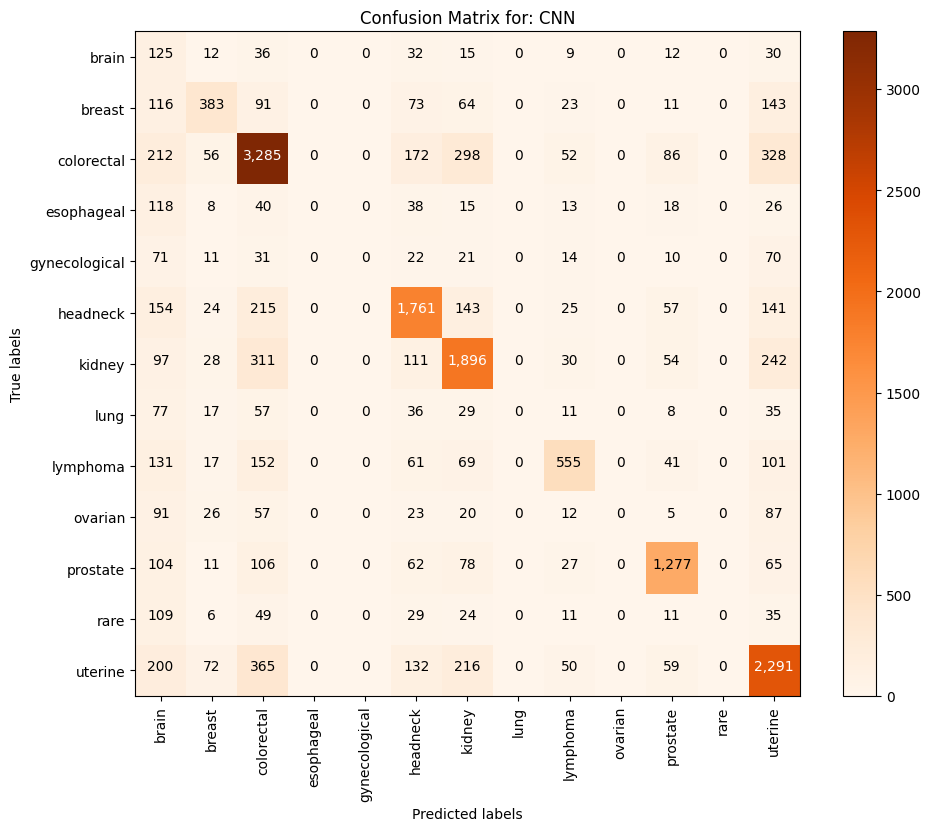

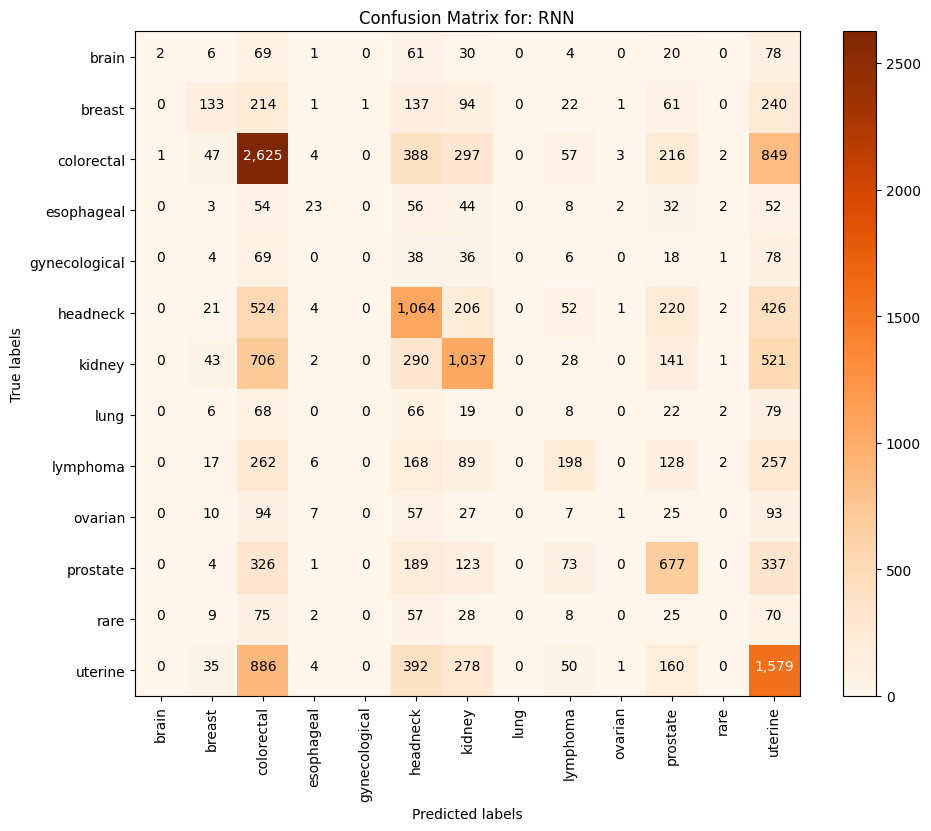

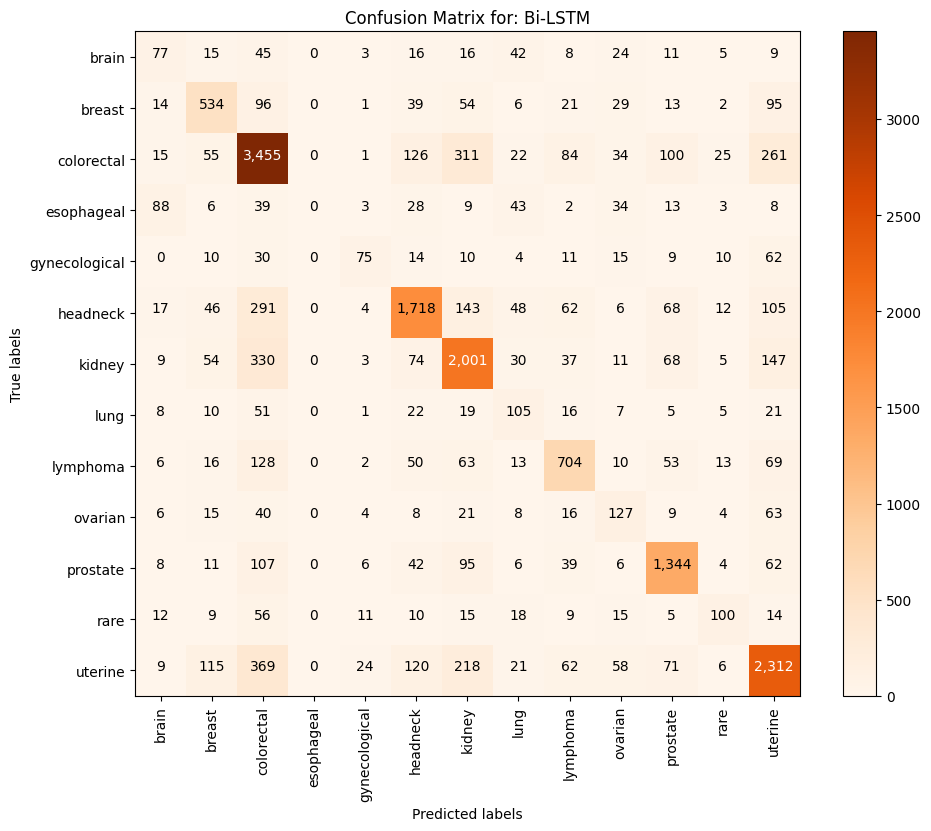

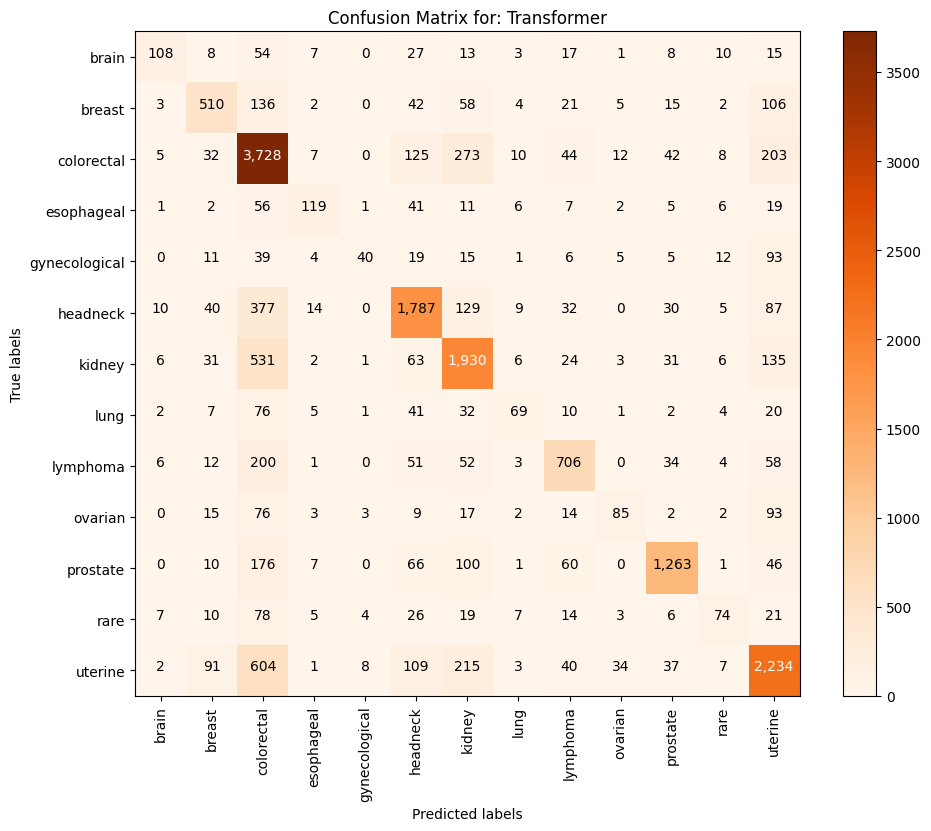

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(model, cm, target_names, cmap=None):
	if cmap is None:
		cmap = plt.get_cmap('Oranges')

	plt.figure(figsize=(10, 8))
	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.colorbar()

	if target_names is not None:
		tick_marks = np.arange(len(target_names))
		plt.xticks(tick_marks, target_names, rotation=90)
		plt.yticks(tick_marks, target_names)

	thresh = cm.max() / 2
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
			plt.text(j, i, "{:,}".format(cm[i, j]),
						horizontalalignment="center",
						color="white" if cm[i, j] > thresh else "black")

	plt.tight_layout()
	plt.title("Confusion Matrix for: " + model)
	plt.ylim(len(target_names)-0.5, -0.5)
	plt.ylabel('True labels')
	plt.xlabel('Predicted labels')
	plt.show()
    
# a tuple for all the class names
target_names = le.classes_

for key in all_cf_matrix:
	plot_confusion_matrix(key, all_cf_matrix[key], target_names)

In [153]:
scores = []
for model in model_true_pred:
	y_true = model_true_pred[model][0]
	y_pred = model_true_pred[model][1]
	scores.append(f1_score(y_true, y_pred, average='weighted'))

In [154]:
pd.DataFrame({"Model": ['CNN', 'RNN', 'Bi-LSTM', 'Transformer'], "F1-Score" : scores})

,Model,F1-Score
0,CNN,0.614822
1,RNN,0.369834
2,Bi-LSTM,0.669625
3,Transformer,0.673350


In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = []
y_pred_lstm = []
y_pred_transformer = []
for inputs, labels in valid_loader:
		output_lstm = model_LSTM(inputs)
		output_lstm = output_lstm.data.cpu().numpy()
		y_pred_lstm.extend(output_lstm)

		output_transformer = model_transformer(inputs)
		output_transformer = output_transformer.data.cpu().numpy()
		y_pred_transformer.extend(output_transformer)
		
		labels = labels.data.cpu().numpy()
		y_true.extend(labels)

In [156]:
y_pred_stack = []
for o1, o2 in zip(y_pred_lstm, y_pred_transformer):
	stacked = np.add(o1, o2)
	y_pred_stack.append(np.argmax(stacked))

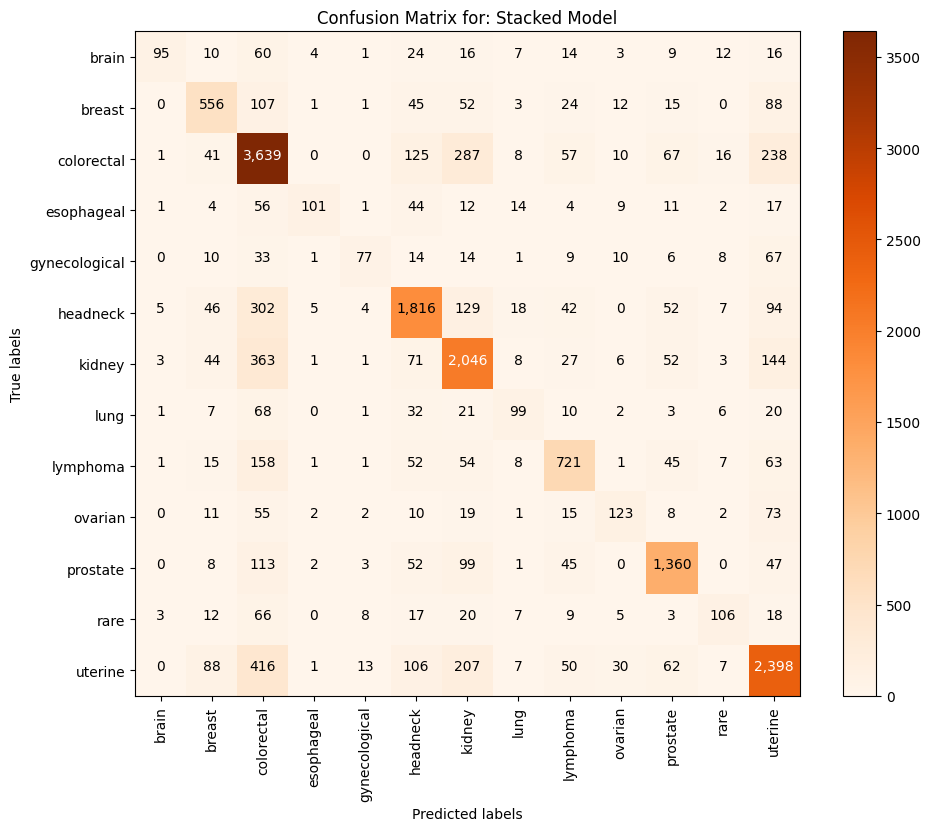

In [157]:
cf_matrix = confusion_matrix(y_true, y_pred_stack)
plot_confusion_matrix('Stacked Model', cf_matrix, target_names)

In [160]:
print("Accuracy:", accuracy_score(y_true, y_pred_stack))
print("F1-Score:", f1_score(y_true, y_pred_stack, average='weighted'))

Accuracy: 0.7068223393952437
F1-Score: 0.7013771382067127


In [171]:
print(classification_report(y_true, y_pred_stack, target_names=['brain', 'breast', 'colorectal', 'esophageal', 'gynecological', 'headneck', 'kidney', 'lung', 'lymphoma', 'ovarian', 'prostate', 'rare', 'uterine'], digits=4))

               precision    recall  f1-score   support

        brain     0.8636    0.3506    0.4987       271
       breast     0.6526    0.6150    0.6333       904
   colorectal     0.6694    0.8106    0.7333      4489
   esophageal     0.8487    0.3659    0.5114       276
gynecological     0.6814    0.3080    0.4242       250
     headneck     0.7542    0.7206    0.7370      2520
       kidney     0.6875    0.7389    0.7123      2769
         lung     0.5440    0.3667    0.4381       270
     lymphoma     0.7020    0.6398    0.6695      1127
      ovarian     0.5829    0.3832    0.4624       321
     prostate     0.8033    0.7861    0.7946      1730
         rare     0.6023    0.3869    0.4711       274
      uterine     0.7304    0.7084    0.7193      3385

     accuracy                         0.7068     18586
    macro avg     0.7017    0.5524    0.6004     18586
 weighted avg     0.7097    0.7068    0.7014     18586

